<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [4]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [9]:
!gdown 1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO -O hw8_dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=2a9ef106-04be-4edc-9442-69ad3a842b3b
To: /Users/adilismailov/Desktop/ИУ9-72Б/Нейронки/hw8_dataset.zip
100%|████████████████████████████████████████| 884M/884M [01:42<00:00, 8.61MB/s]


In [16]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 108 ms, sys: 358 ms, total: 466 ms
Wall time: 723 ms



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [17]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [18]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [19]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

for img_captions in captions:
    for caption in img_captions:
        for word in caption:
            word_counts[word] += 1

print(f"unique words: {len(word_counts)}")

unique words: 29416


In [20]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [21]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [22]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [23]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [27]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(
            input_size=emb_size,     
            hidden_size=lstm_units,   
            batch_first=True          
        )

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid[None], initial_cell[None]))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [28]:
network = CaptionNet(n_tokens)

In [29]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [34]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(
        logits_for_next.view(-1, logits_for_next.shape[-1]),  
        captions_ix_next.view(-1),                             
        ignore_index=pad_ix                                    
    ).unsqueeze(0)

    return loss

In [35]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [38]:
import torch.optim as optim

In [39]:
lr = 1e-3
optimizer = optim.Adam(network.parameters(),  lr=lr)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [49]:
from sklearn.model_selection import train_test_split
captions_np = np.array(captions, dtype=object)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions_np,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [52]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = [np.random.choice(caps) for caps in captions_for_batch_images]

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [53]:
generate_batch(img_codes,captions_np,3)

(tensor([[0.4039, 0.3261, 0.5263,  ..., 0.1321, 1.2976, 0.1855],
         [0.0797, 0.3381, 0.4973,  ..., 0.0193, 0.3146, 0.7890],
         [0.4234, 0.4928, 0.3381,  ..., 0.0086, 0.2661, 0.1547]]),
 tensor([[   1,   24,  106,   14,  115,   89, 2139,   58,   24, 2151,   35,   77,
            14,   24,  307,   12,    2],
         [   1,   24,   57,  226,    6,   54,   35,   24,  497,    6,   45,   19,
            12,    2,    3,    3,    3],
         [   1,   24,  272,  126,  705,  140,  303,   24,  184,   12,    2,    3,
             3,    3,    3,    3,    3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [54]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [55]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=5.0)
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.63it/s]



Epoch: 0, train loss: 6.030073385238648, val loss: 4.988590812683105


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.33it/s]



Epoch: 1, train loss: 4.733627376556396, val loss: 4.542324733734131


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.31it/s]



Epoch: 2, train loss: 4.459632635116577, val loss: 4.345065784454346


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.63it/s]



Epoch: 3, train loss: 4.2494465398788455, val loss: 4.15515251159668


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.12it/s]



Epoch: 4, train loss: 4.135463638305664, val loss: 4.040188360214233


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.78it/s]



Epoch: 5, train loss: 4.06377715587616, val loss: 3.968707275390625


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.17it/s]



Epoch: 6, train loss: 3.928207588195801, val loss: 3.88734712600708


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]



Epoch: 7, train loss: 3.8667932653427126, val loss: 3.8262022972106933


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.95it/s]



Epoch: 8, train loss: 3.8067281579971315, val loss: 3.8609491348266602


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.85it/s]



Epoch: 9, train loss: 3.7216768646240235, val loss: 3.6084768772125244


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.57it/s]



Epoch: 10, train loss: 3.6207211446762084, val loss: 3.5729657649993896


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.22it/s]



Epoch: 11, train loss: 3.5402502822875976, val loss: 3.5773372650146484


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.44it/s]



Epoch: 12, train loss: 3.5495967769622805, val loss: 3.4126450538635256


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.86it/s]



Epoch: 13, train loss: 3.4782249450683596, val loss: 3.4887996673583985


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.92it/s]



Epoch: 14, train loss: 3.4562233781814573, val loss: 3.3245246410369873


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.58it/s]



Epoch: 15, train loss: 3.4111636447906495, val loss: 3.3796942710876463


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.81it/s]



Epoch: 16, train loss: 3.349500069618225, val loss: 3.3884238243103026


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s]



Epoch: 17, train loss: 3.3087323999404905, val loss: 3.32257399559021


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.99it/s]



Epoch: 18, train loss: 3.3162084436416626, val loss: 3.245301389694214


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.04it/s]



Epoch: 19, train loss: 3.2987636041641237, val loss: 3.167432403564453


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.51it/s]



Epoch: 20, train loss: 3.2308919477462767, val loss: 3.2066236972808837


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.08it/s]



Epoch: 21, train loss: 3.243840732574463, val loss: 3.133154773712158


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.80it/s]



Epoch: 22, train loss: 3.210171627998352, val loss: 3.136499118804932


100%|███████████████████████████████████████████| 50/50 [00:07<00:00,  6.98it/s]



Epoch: 23, train loss: 3.1634810256958006, val loss: 3.110762691497803


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.53it/s]



Epoch: 24, train loss: 3.149214358329773, val loss: 3.1537639141082763


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.87it/s]



Epoch: 25, train loss: 3.1316799211502073, val loss: 3.1299949169158934


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.69it/s]



Epoch: 26, train loss: 3.0817694568634035, val loss: 3.0007931709289553


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.59it/s]



Epoch: 27, train loss: 3.137100486755371, val loss: 3.0665870666503907


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.91it/s]



Epoch: 28, train loss: 3.0626748275756834, val loss: 3.228607940673828


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.95it/s]



Epoch: 29, train loss: 3.0522739934921264, val loss: 3.0940671443939207


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.87it/s]



Epoch: 30, train loss: 3.065544939041138, val loss: 3.0435850620269775


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.86it/s]



Epoch: 31, train loss: 3.0353591632843018, val loss: 2.956887626647949


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.96it/s]



Epoch: 32, train loss: 3.0233393049240114, val loss: 3.1030985832214357


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.16it/s]



Epoch: 33, train loss: 2.9729366731643676, val loss: 2.9890541076660155


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.97it/s]



Epoch: 34, train loss: 2.9831138753890993, val loss: 2.8583182811737062


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.49it/s]



Epoch: 35, train loss: 2.9566811895370484, val loss: 2.88722243309021


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.08it/s]



Epoch: 36, train loss: 2.925017056465149, val loss: 3.0185776233673094


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.10it/s]



Epoch: 37, train loss: 2.95142644405365, val loss: 2.854660415649414


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.85it/s]



Epoch: 38, train loss: 2.932566909790039, val loss: 3.0639278411865236


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.22it/s]



Epoch: 39, train loss: 2.909021272659302, val loss: 2.9968258857727053


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.08it/s]



Epoch: 40, train loss: 2.9090673875808717, val loss: 2.8488918781280517


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.29it/s]



Epoch: 41, train loss: 2.9079963541030884, val loss: 2.855294609069824


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.04it/s]



Epoch: 42, train loss: 2.906360387802124, val loss: 2.9300700187683106


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.38it/s]



Epoch: 43, train loss: 2.854591579437256, val loss: 2.9227315902709963


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.53it/s]



Epoch: 44, train loss: 2.881912407875061, val loss: 2.8894826889038088


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.04it/s]



Epoch: 45, train loss: 2.835528769493103, val loss: 2.8911972522735594


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]



Epoch: 46, train loss: 2.8643226480484008, val loss: 2.984237623214722


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.20it/s]



Epoch: 47, train loss: 2.844099259376526, val loss: 2.947983503341675


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.79it/s]



Epoch: 48, train loss: 2.854416217803955, val loss: 2.8858495712280274


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.29it/s]



Epoch: 49, train loss: 2.8230610847473145, val loss: 2.858291006088257


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.69it/s]



Epoch: 50, train loss: 2.82891610622406, val loss: 2.832936716079712


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.16it/s]



Epoch: 51, train loss: 2.81163357257843, val loss: 2.8017463207244875


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.35it/s]



Epoch: 52, train loss: 2.8134733772277833, val loss: 2.8576454162597655


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s]



Epoch: 53, train loss: 2.8255176877975465, val loss: 2.7842699527740478


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.16it/s]



Epoch: 54, train loss: 2.8009898900985717, val loss: 2.7837013721466066


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.26it/s]



Epoch: 55, train loss: 2.8467090272903444, val loss: 2.872167634963989


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.62it/s]



Epoch: 56, train loss: 2.8026821994781494, val loss: 2.861532735824585


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.01it/s]



Epoch: 57, train loss: 2.8048445272445677, val loss: 2.9104566097259523


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.96it/s]



Epoch: 58, train loss: 2.778890690803528, val loss: 2.851673698425293


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.83it/s]



Epoch: 59, train loss: 2.760692162513733, val loss: 2.781662368774414


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.26it/s]



Epoch: 60, train loss: 2.7792990827560424, val loss: 2.758024263381958


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.90it/s]



Epoch: 61, train loss: 2.7578609800338745, val loss: 2.7666089057922365


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.48it/s]



Epoch: 62, train loss: 2.7922902631759645, val loss: 2.797558546066284


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.27it/s]



Epoch: 63, train loss: 2.7620544815063477, val loss: 2.866818571090698


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.24it/s]



Epoch: 64, train loss: 2.7596629810333253, val loss: 2.807481384277344


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.10it/s]



Epoch: 65, train loss: 2.7966192960739136, val loss: 2.796336603164673


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.16it/s]



Epoch: 66, train loss: 2.765342903137207, val loss: 2.7462610721588137


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.47it/s]



Epoch: 67, train loss: 2.7441923141479494, val loss: 2.7941792488098143


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.74it/s]



Epoch: 68, train loss: 2.72636652469635, val loss: 2.848549795150757


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.83it/s]



Epoch: 69, train loss: 2.770919623374939, val loss: 2.7606289863586424


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.65it/s]



Epoch: 70, train loss: 2.6994427108764647, val loss: 2.8039546966552735


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.14it/s]



Epoch: 71, train loss: 2.717333960533142, val loss: 2.8077617645263673


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.03it/s]



Epoch: 72, train loss: 2.7563459777832033, val loss: 2.71070876121521


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.95it/s]



Epoch: 73, train loss: 2.7230707740783693, val loss: 2.615551710128784


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.61it/s]



Epoch: 74, train loss: 2.7207861709594727, val loss: 2.807712936401367


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.13it/s]



Epoch: 75, train loss: 2.692842025756836, val loss: 2.665568733215332


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.36it/s]



Epoch: 76, train loss: 2.7101010942459105, val loss: 2.6851154804229735


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.24it/s]



Epoch: 77, train loss: 2.727538685798645, val loss: 2.829566240310669


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.55it/s]



Epoch: 78, train loss: 2.71357186794281, val loss: 2.7086936950683596


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.92it/s]



Epoch: 79, train loss: 2.721788320541382, val loss: 2.5264955043792723


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.82it/s]



Epoch: 80, train loss: 2.6648162460327147, val loss: 2.7002650260925294


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.88it/s]



Epoch: 81, train loss: 2.685609884262085, val loss: 2.8092028141021728


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.01it/s]



Epoch: 82, train loss: 2.714245038032532, val loss: 2.7624743938446046


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.48it/s]



Epoch: 83, train loss: 2.6896987104415895, val loss: 2.6216071605682374


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.97it/s]



Epoch: 84, train loss: 2.6695205926895142, val loss: 2.6111305236816404


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.87it/s]



Epoch: 85, train loss: 2.6717973279953005, val loss: 2.693000841140747


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.57it/s]



Epoch: 86, train loss: 2.692989926338196, val loss: 2.7630024433135985


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.74it/s]



Epoch: 87, train loss: 2.661679563522339, val loss: 2.638916349411011


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.26it/s]



Epoch: 88, train loss: 2.6455506038665773, val loss: 2.714339256286621


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.02it/s]



Epoch: 89, train loss: 2.677645034790039, val loss: 2.738916826248169


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.12it/s]



Epoch: 90, train loss: 2.663034176826477, val loss: 2.6970357418060305


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.73it/s]



Epoch: 91, train loss: 2.661041564941406, val loss: 2.7022098541259765


100%|███████████████████████████████████████████| 50/50 [00:07<00:00,  7.09it/s]



Epoch: 92, train loss: 2.670990381240845, val loss: 2.5728883743286133


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.43it/s]



Epoch: 93, train loss: 2.6899230003356935, val loss: 2.7373799324035644


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.93it/s]



Epoch: 94, train loss: 2.6561806535720827, val loss: 2.865348529815674


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.51it/s]



Epoch: 95, train loss: 2.6241859674453734, val loss: 2.719854497909546


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.43it/s]



Epoch: 96, train loss: 2.6539937686920165, val loss: 2.674380159378052


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.52it/s]



Epoch: 97, train loss: 2.6649303436279297, val loss: 2.728813123703003


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.13it/s]



Epoch: 98, train loss: 2.663797125816345, val loss: 2.8275002002716065


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.07it/s]



Epoch: 99, train loss: 2.64935839176178, val loss: 2.63651123046875
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [56]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /Users/adilismailov/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|█████████████████████████████████████████| 104M/104M [02:19<00:00, 782kB/s]


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [57]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [69]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

# Скачиваем изображение
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg

img = Image.open('data/img.jpg')
img = img.resize((299, 299))
img = np.array(img).astype('float32') / 255.

--2025-11-06 01:10:55--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Распознаётся pixel.nymag.com (pixel.nymag.com)… 199.232.173.246
Подключение к pixel.nymag.com (pixel.nymag.com)|199.232.173.246|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [переход]
--2025-11-06 01:10:55--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Распознаётся pyxis.nymag.com (pyxis.nymag.com)… 199.232.173.246
Подключение к pyxis.nymag.com (pyxis.nymag.com)|199.232.173.246|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 54731 (53K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>]  53,45K  --.-KB/s    за 0,06s   

2025-11-06 01:10:55 (966 KB/s) - «data/img.jpg» сохранён [54731/54731]



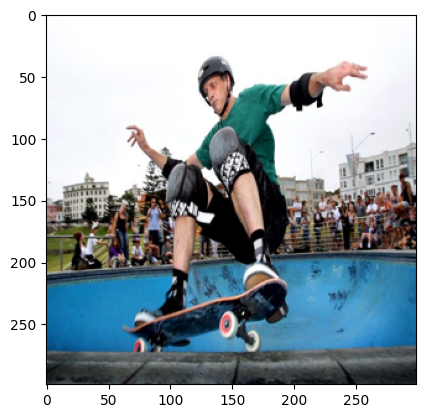

In [70]:
plt.imshow(img)

In [71]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man in a wetsuit riding a skateboard in the air .
a man on a skateboard doing a trick .
a man riding a skateboard on a ramp .
a man in a red shirt riding a skateboard .
a man riding a skateboard on a ramp .
a man in a red shirt is riding a skateboard .
a man doing a trick on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard in the air .
a man on a skateboard doing a trick


### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

Модифицируем метод **generate_caption** - будем накапливать вероятности каждой аннотации по формуле произведения вероятностей. Для лучшей устойчивости прологарифмируем эту формулу, т.е. будем накапливать логарифм вероятности аннотации.
![img](https://github.com/Nustle/VK-Education/blob/main/NN/hw8/proba.png)

In [109]:
def generate_caption_with_prob(image, caption_prefix=("#START#",),
                               t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1 \
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(image[None])
        
        caption_prefix = list(caption_prefix)
        log_prob = 0.0  
        
        for _ in range(max_len):
            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()
            
            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)
            
            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]
            
            word_idx = word_to_index[next_word]
            log_prob += np.log(next_word_probs[word_idx] + 1e-10)
            
            caption_prefix.append(next_word)
            
            if next_word == "#END#":
                break
        
        return caption_prefix, log_prob

In [112]:
def generate_best_caption(image, n_captions=10):
    all_captions = []
    
    for _ in range(n_captions):
        caption, log_prob = generate_caption_with_prob(image, t=5.)
        all_captions.append((caption, log_prob))
    
    all_captions.sort(key=lambda x: x[1], reverse=True)
    
    best_caption, best_prob = all_captions[0]
    
    return best_caption

Сначала выведем примеры картинок, для которых модель хорошо выдаёт аннотацию.

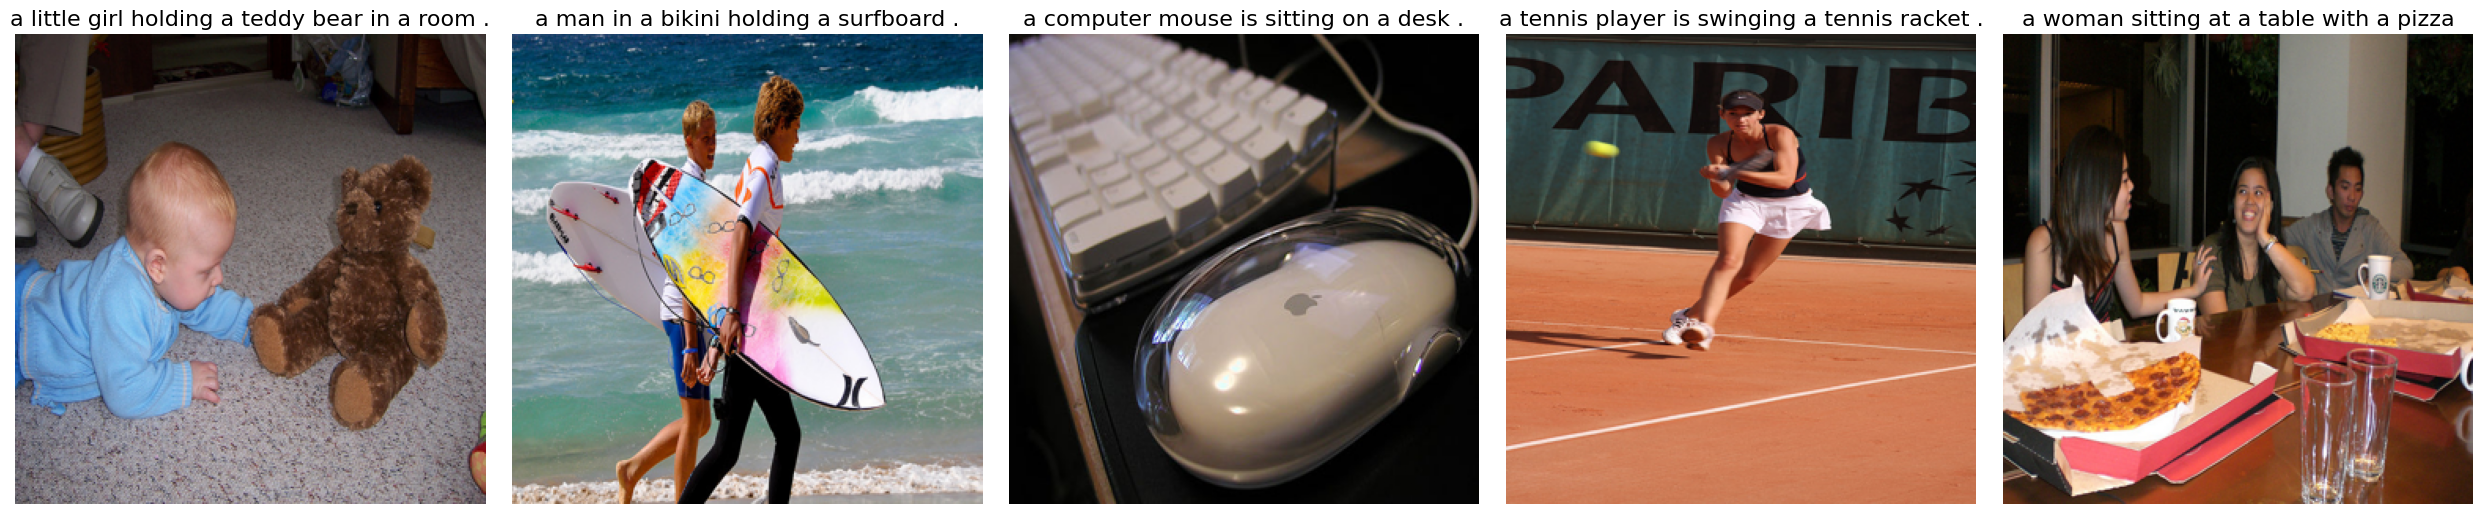

In [129]:
images_good = ['12', '14', '23', '25', '13']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, img_path in enumerate(images_good):
    img = Image.open(f'data/{img_path}.jpg')
    img = img.resize((299, 299))
    img_array = np.array(img).astype('float32') / 255.
    
    best_caption = generate_best_caption(img_array)
    caption_text = ' '.join(best_caption[1:-1])  
    
    axes[idx].imshow(img_array)
    axes[idx].set_title(f'{caption_text}', fontsize=16, wrap=True)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Теперь выведем картинки, для которых модель выдаёт частично правильные аннотации

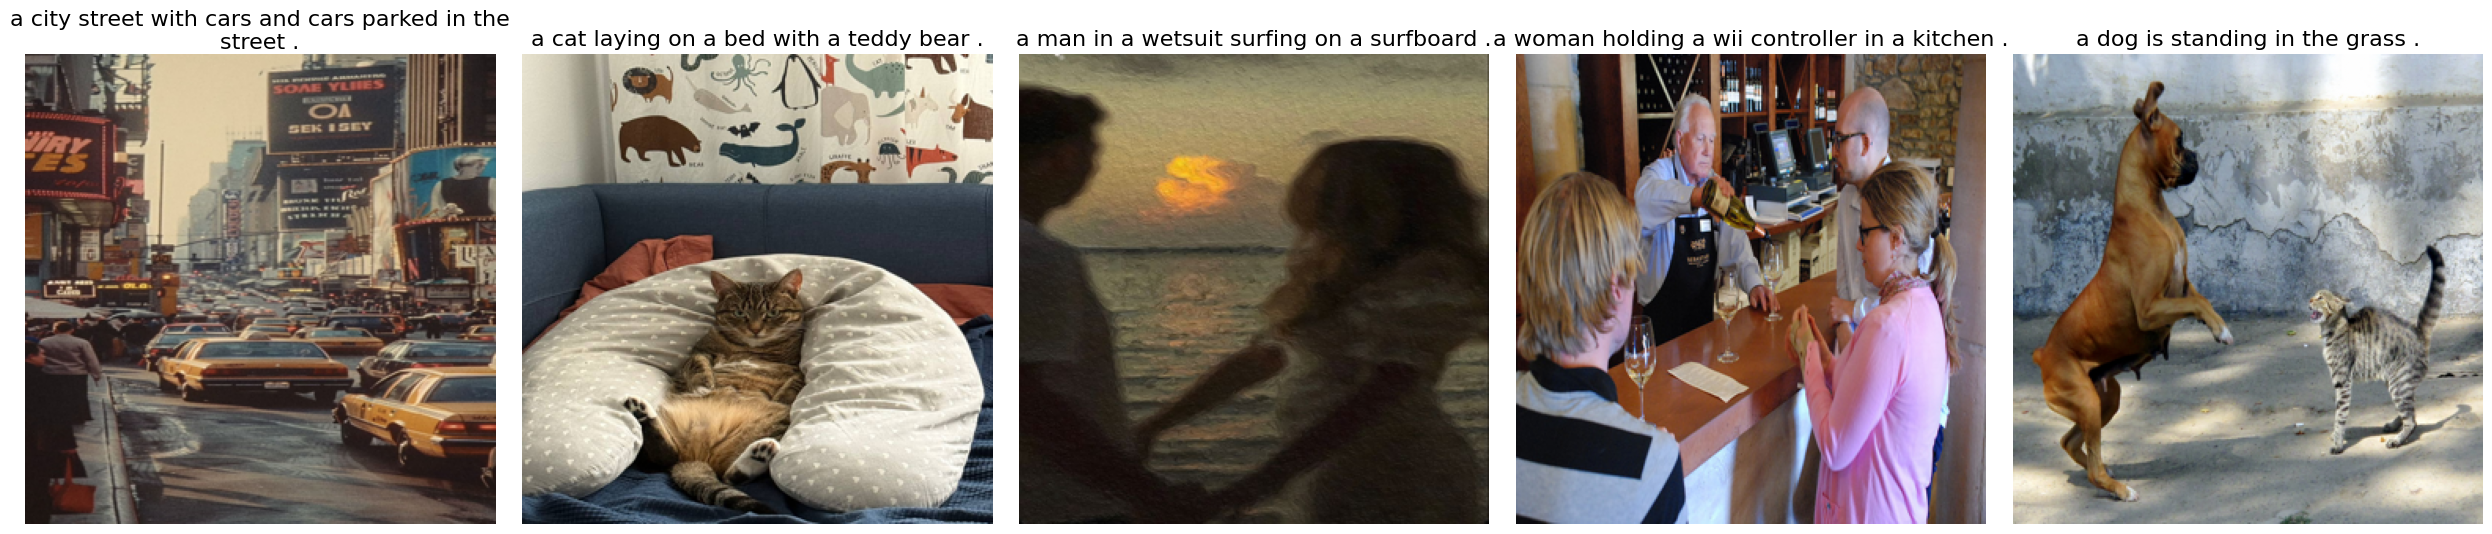

In [136]:
images_norm = ['26', '6', '30', '24', '31']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, img_path in enumerate(images_norm):
    img = Image.open(f'data/{img_path}.jpg')
    img = img.resize((299, 299))
    img_array = np.array(img).astype('float32') / 255.
    
    best_caption = generate_best_caption(img_array)
    caption_text = ' '.join(best_caption[1:-1])  
    
    axes[idx].imshow(img_array)
    axes[idx].set_title(f'{caption_text}', fontsize=16, wrap=True)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Ну а теперь аннотации, для которых модель выдаёт неточные аннотации

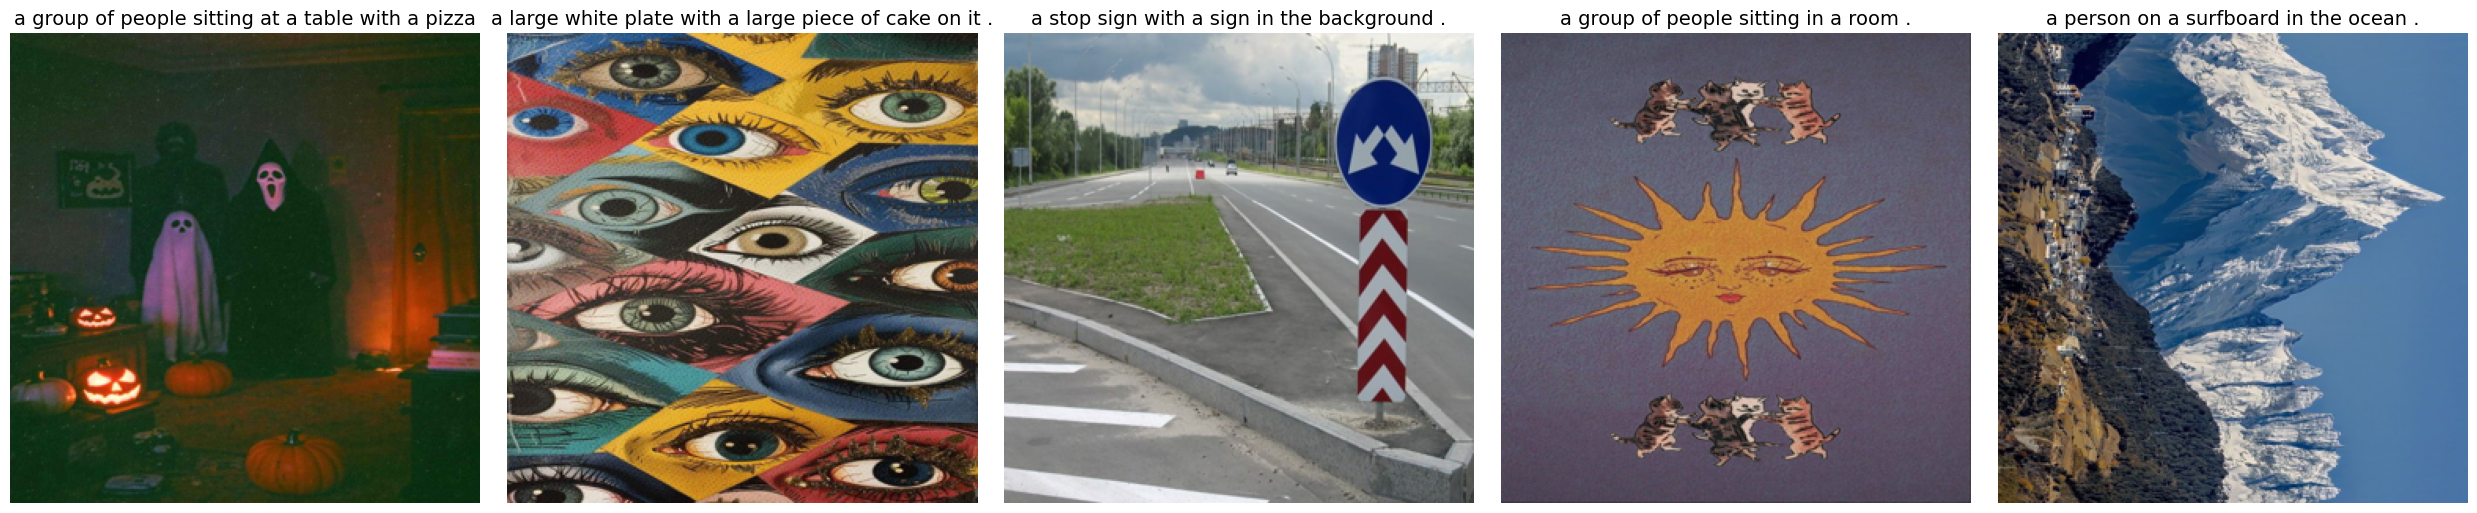

In [139]:
images_bad = ['27', '29', '22', '32', '34']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, img_path in enumerate(images_bad):
    img = Image.open(f'data/{img_path}.jpg')
    img = img.resize((299, 299))
    img_array = np.array(img).astype('float32') / 255.
    
    best_caption = generate_best_caption(img_array)
    caption_text = ' '.join(best_caption[1:-1])  
    
    axes[idx].imshow(img_array)
    axes[idx].set_title(f'{caption_text}', fontsize=14, wrap=True)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Из примеров видно, что модели не хвататет слов в словаре. Особенно это видно для images_norm: начало аннотации правильное, а вот в конце модель пытается вствить что-то из того, что знает, и что похоже на картинку (например, картинка с кошкой, лежащей на подушке). А если модель не видела какие-то картинки при обучении, то она опирается на общие паттерны изображения, в соответствии с которыми выдаёт аннотацию (например перевёрнутая картинка с горами, которая визуально с небом похожа на океан).


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
